In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import random 


# Data import

In [14]:
df = pd.read_csv("pheno_terpenoids.tsv",sep="\t",index_col=0)
df.head()

,wf,thrips,5.541_67.0557,7.060_95.0168,9.272_93.0728,9.472_91.0566,9.653_91.0565,10.148_93.0730,10.581_105.0363,10.873_119.0877,...,26.529_131.0872,26.595_91.0568,26.689_109.1032,26.803_111.0836,26.833_81.0727,27.083_97.0317,27.996_91.0565,28.382_97.0323,30.160_91.0569,32.503_159.8606
sample,,,,,,,,,,,,,,,,,,,,,
S lyc MM,non-toxic,non-toxic,0.00000,0.0,0.0000,0.000000,88210.77165,0.00000,0.0,32617.13711,...,0.0,0.000,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0
S hua LA1364,non-toxic,non-toxic,0.00000,0.0,104528.7520,45335.466500,27304.44693,90430.09761,0.0,0.00000,...,0.0,0.000,0.0,5561.18023,0.00000,0.0,0.0,0.0,0.0,0.0
S pim LA1578,non-toxic,non-toxic,12809.66965,0.0,0.0000,0.000000,221391.28520,0.00000,0.0,24737.81096,...,0.0,0.000,0.0,9495.49648,0.00000,0.0,0.0,0.0,0.0,0.0
S hab LA1718,toxic,non-toxic,0.00000,0.0,0.0000,0.000000,436434.76200,0.00000,0.0,0.00000,...,0.0,121073.917,0.0,0.00000,15089.64365,0.0,0.0,0.0,0.0,0.0
S chm LA1840,non-toxic,non-toxic,0.00000,0.0,13354.2292,7006.160718,138245.88960,18838.74620,0.0,0.00000,...,0.0,0.000,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0


## get the X and y arrays

In [15]:
# get whitefly classes
y = df["wf"].tolist()
stratify_info = df['wf'].map({'non-toxic': 0, 'toxic': 1})

# get matrix X of volatile values
X = df.iloc[:,2:]
X.head()

,5.541_67.0557,7.060_95.0168,9.272_93.0728,9.472_91.0566,9.653_91.0565,10.148_93.0730,10.581_105.0363,10.873_119.0877,11.056_91.0567,11.572_91.0564,...,26.529_131.0872,26.595_91.0568,26.689_109.1032,26.803_111.0836,26.833_81.0727,27.083_97.0317,27.996_91.0565,28.382_97.0323,30.160_91.0569,32.503_159.8606
sample,,,,,,,,,,,,,,,,,,,,,
S lyc MM,0.00000,0.0,0.0000,0.000000,88210.77165,0.00000,0.0,32617.13711,0.0,0.00000,...,0.0,0.000,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0
S hua LA1364,0.00000,0.0,104528.7520,45335.466500,27304.44693,90430.09761,0.0,0.00000,0.0,624085.81700,...,0.0,0.000,0.0,5561.18023,0.00000,0.0,0.0,0.0,0.0,0.0
S pim LA1578,12809.66965,0.0,0.0000,0.000000,221391.28520,0.00000,0.0,24737.81096,0.0,0.00000,...,0.0,0.000,0.0,9495.49648,0.00000,0.0,0.0,0.0,0.0,0.0
S hab LA1718,0.00000,0.0,0.0000,0.000000,436434.76200,0.00000,0.0,0.00000,0.0,0.00000,...,0.0,121073.917,0.0,0.00000,15089.64365,0.0,0.0,0.0,0.0,0.0
S chm LA1840,0.00000,0.0,13354.2292,7006.160718,138245.88960,18838.74620,0.0,0.00000,0.0,34923.75849,...,0.0,0.000,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0


# Random Forest analysis 

## Extract feature importance from the RF runs

In [8]:
from helper_functions import extract_feature_importance_avg_and_sd_from_multiple_random_forest_runs

# generates a list with first element average and second element standard deviation
feature_importances = extract_feature_importance_avg_and_sd_from_multiple_random_forest_runs(
    X,
    y,
    nb_of_splits=6,
    nb_of_trees=1000,
    nb_of_runs=5
)

In [9]:
# determine the average en std deviations 
mean_varimportance = feature_importances[0].mean(axis=1)

# sum the variances (=squared std) and then take the mean
pooled_std = np.sqrt((feature_importances[1]**2).mean(axis=1))

# create panda for convenience
yerr = pd.concat([mean_varimportance-2*pooled_std, mean_varimportance,mean_varimportance+2*pooled_std],axis=1)

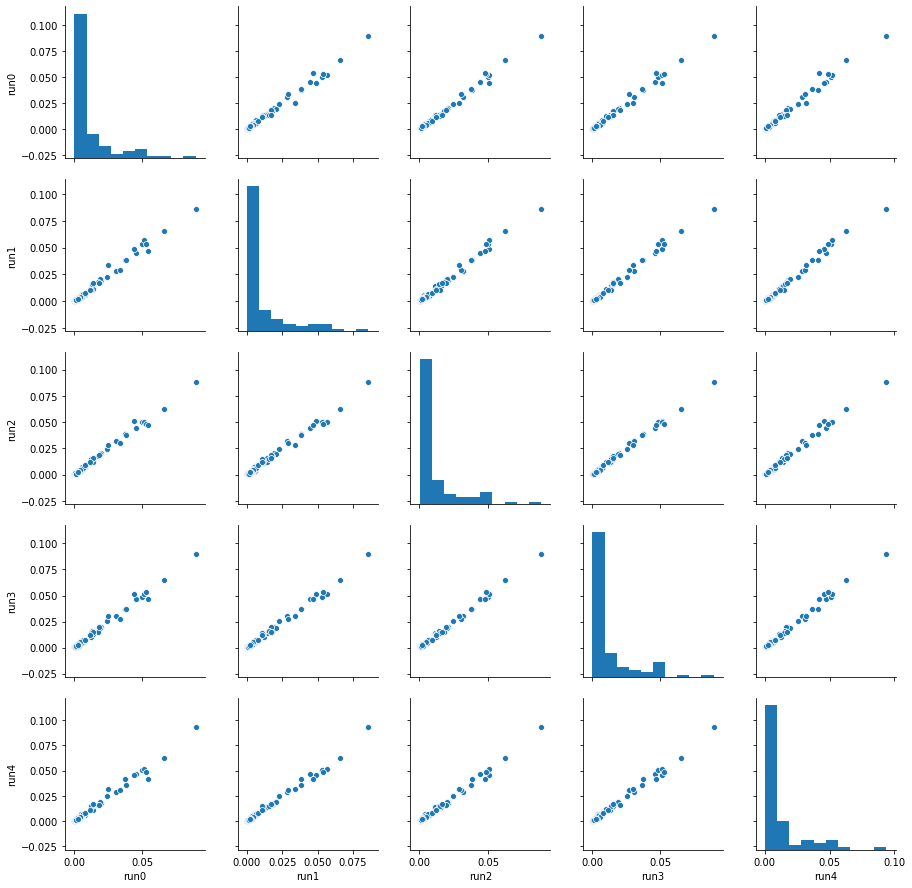

In [12]:
# plot the variable importances for each run and compare them to each other -> gives idea of stability 
sns.pairplot(data=feature_importances[0])

# Permutations to extract p-values for each feature importance

In [ ]:
nrperm = 2
yperms = pd.DataFrame(columns=['perm{0}'.format(i+1) for i in range(nrperm)])
secure_random = random.SystemRandom()

In [ ]:
feature_importance_perm=pd.DataFrame(columns=['perm{0}'.format(i+1) for i in range(nrperm)])
yhat_perm=pd.DataFrame(columns=['perm{0}'.format(i+1) for i in range(nrperm)])

# create dataframe with y vector
dfy = pd.DataFrame(y,columns=['tox'])


for perm in range(nrperm):    
    # generate random numbers
    randomfloat = [secure_random.random() for r in range(len(y))]
    # create new ynew matrix
    ynew = dfy.iloc[np.argsort(randomfloat)]
    # reindex the vector
    ynew.index = range(len(y))
    # store this matrix for later
    yperms.iloc[:,perm]=ynew.iloc[:,0].copy()
    
    # set to fixed seed 1234 (arbitraryly)
    a,yh = single_run(X,ynew,1234,False)
    feature_importance_perm.iloc[:,perm] = a.mean(axis=1)
    yhat_perm.iloc[:,perm]=yh.iloc[:,0]
    

In [ ]:
# routine to determine pvalue of average value (x) based on results scored by random generated data (X)
def iperc(x,X):
    
    df = pd.DataFrame(index=X.index,columns=['p-value'])
    
    for i in range(len(x)):            
        pn = sum(X.iloc[i,:]<x.iloc[i])/X.shape[0]
        pp = sum(X.iloc[i,:]>=x.iloc[i])/X.shape[0]
    
        df.iloc[i] = min(pn,pp)
            
    return df
    

In [ ]:
# create some pandas just for plotting 
minp = feature_importance_perm.min(axis=1)
maxp = feature_importance_perm.max(axis=1)

yerr_plot = pd.concat([minp, mean_varimportance,maxp],axis=1)
yerr_plot.columns = ['min_perm','avg','max_perm']
yerr_plot['sig']=(minp>mean_varimportance) | (maxp<mean_varimportance)
yerr_plot['x'] = range(yerr.shape[0])

In [ ]:
fig,ax = plt.subplots(figsize=([5,5]),dpi=200)
ax.set(yscale='log')
sns.scatterplot(x='x',y='avg',data=yerr_plot,markers=['o','^'],hue='sig',style='sig')
sns.lineplot(x='x',y='min_perm',data=yerr_plot,color='red')
sns.lineplot(x='x',y='max_perm',data=yerr_plot,color='green')

ax.lines[0].set_linestyle('--')
ax.lines[0].set_linewidth(1)

ax.lines[1].set_linestyle('--')
ax.lines[1].set_linewidth(1)

plt.legend(['min','max','avg'])

plt.xlabel('variable index')
plt.ylabel('importance');


In [ ]:
mi = mean_varimportance
pvalues = iperc(mi,feature_importance_perm)
sns.distplot(pvalues.iloc[:,0].astype('float'),20)
plt.title('distribution of obseverd p-values');

In [ ]:
pvalues.loc[pvalues['p-value']<0.05,:]

In [ ]:
# only select those variables that have p-value smaller than 0.05 (after bonferroni correction)
#mysel = pvalues.loc[pvalues.iloc[:,0]<(0.05/X.shape[0]),:].sort_values('p-value')
mysel = pvalues.loc[pvalues.iloc[:,0]<0.05,:].sort_values('p-value')

In [ ]:
# plot those variables
nrplots = len(mysel.index.values)
fig = plt.figure(figsize=([3,12]),dpi=150)
ax = fig.subplots(nrows=nrplots,ncols=1)

yerr = pd.concat([mean_varimportance-2*pooled_std, mean_varimportance,mean_varimportance+2*pooled_std],axis=1)

for i in range(nrplots):                
    plt.subplot(ax[i])
    sns.distplot(feature_importance_perm.iloc[mysel.index.values[i],:],bins=10,ax=ax[i])
    plt.plot(mi[mysel.index.values[i]],0,mi[mysel.index.values[i]],50,'o')
    plt.plot(yerr.iloc[mysel.index.values[i],0],0,yerr.iloc[mysel.index.values[i],0],50,'^')
    plt.plot(yerr.iloc[mysel.index.values[i],2],0,yerr.iloc[mysel.index.values[i],2],50,'v')

    
plt.tight_layout()

# Write final results to file

In [ ]:
df.head()

In [ ]:
# here an extra check.. set p-value < 0.05 AND rsd < 0.25 

adf = pd.concat([pvalues,pooled_std,mean_varimportance,pooled_std/mean_varimportance],axis=1)
adf.rename(columns={0:'std',1:'avg',2:'rsd'},inplace=True);
signif = adf.loc[adf['p-value'] < 0.05]
print(signif)

In [ ]:
X.iloc[:,signif.index.values]

## Sort dataframe by phenotypic class
To display a heatmap that shows the rows of the non-toxic genotypes followed by the rows of the toxic genotypes.

In [ ]:
df_sorted = df.sort_values(by=["wf"])

# make a new column containing the accession and phenotypic class
df_sorted["genotypes and class"] = df_sorted.index.values + "_" + df_sorted["wf"]
df_sorted = df_sorted.set_index(df_sorted["genotypes and class"])

In [ ]:
# X matrix similar to the one used for the Random Forest analysis (rows are reordered, not columns)
X = df_sorted.iloc[:,2:]

# add one for log offset
X_disp = X.replace(0,1) 

# display heatmap of log2(values)
log_function = lambda x: np.log2(x)
sns.heatmap(X_disp.iloc[:,signif.index.values].apply(log_function),cmap="Blues")

In [ ]:
# filter to keep only significant metabolites
X_filt = X.iloc[:,signif.index.values]

# Make plots for each candidate summing over the class

In [ ]:
# insert a column with the genotype + class
X_filt.insert(loc=0,column="id",value=X_filt.index.values)

In [ ]:
# new data frame with split value columns 
new = X_filt["id"].str.split("_", n = 1, expand = True) 
  
# making separate last name column from new data frame 
X_filt.loc[:,"wf"]= new[1]

# add index column
X_filt = X_filt.set_index("id")

In [ ]:
toxic = X_filt.iloc[:,0:-1][X_filt["wf"] == "toxic"].sum()

In [ ]:
nontoxic = X_filt.iloc[:,0:-1][X_filt["wf"] == "non-toxic"].sum()

In [ ]:
# prepare a dataframe for plotting
sumByClass = pd.DataFrame({'toxic':toxic, 'non-toxic':nontoxic})
sumByClass = sumByClass.reset_index()
sumByClass.columns.values[0]="candidate"
sumByClass = sumByClass.melt(id_vars="candidate",var_name="class",value_name="value")

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
ax.set_xscale("log",basex=2)
sns.barplot(x="value",y="candidate",hue="class",data=sumByClass,ax=ax)

In [ ]:
sumByClass

# Step-wise selection

This analysis is different because we will use a filtered dataset based on the results using the original, non-filtered dataset.

Significant volatiles that are only detected in the whitefly *non-toxic* class are taken out from the original dataset. That is, their abundance in the *toxic* class should be equal to 0 (not detected in the toxic genotypes).

Indeed, these volatiles are too discriminant between the two classes and thus these volatiles get a very high feature importance. As the goal of this analysis is also to get significant volatiles that are either present in both classes (but quantitatively different) or only detectable in the *toxic* class. 

**Which of the candidate have a value of 0 in the toxic class but a value > 0 in the non-toxic class?**

In [ ]:
candidates_to_drop = sumByClass[(sumByClass["class"] == "toxic") & (sumByClass["value"] == 0)]["candidate"].tolist()
candidates_to_drop

In [ ]:
df = pd.read_csv("pheno_terpenoids.tsv",sep="\t",index_col=0)
print(df.shape)
df.head()

In [ ]:
# remove the 3 volatiles with an abundance equal to zero in the toxic class
df = df.drop(columns=candidates_to_drop)
df.shape

## Define modified X and unmodified y arrays

In [ ]:
# get whitefly classes
y = df["wf"].tolist()
stratify_info = df['wf'].map({'non-toxic': 0, 'toxic': 1})

# get matrix X of volatile values
X = df.iloc[:,2:]
X.head()

In [ ]:
from helper_functions import single_random_forest_run

res = single_random_forest_run(X,y,disp=False,rs=1234,nb_of_splits=6,nb_of_trees=1000)

In [ ]:
res[2]

In [ ]:
dfy = pd.DataFrame(y,columns=['tox'])

In [ ]:
dfy